In [1]:
import cv2
import dlib
import pywt
import os
import glob
import sys
import math 
import imutils
from imutils import face_utils
from PIL import Image
import tensorflow as tf
import face_recognition
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,LSTM,TimeDistributed,GlobalAveragePooling2D,Flatten,Conv2D,ConvLSTM2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [2]:
drive = os.getcwd()
classes = ['anger','contempt','disgust','fear','happy','sadness','surprise']
print(drive)

# test_images = [cv2.imread(file) for file in glob.glob(drive+'\\jj\\*')]
# img_size = 224
# training_data = []
# datadirectory = drive+'\\CK+48\\'

# def creating_training_data():
#     for category in classes:
#         path = os.path.join(datadirectory, category)
#         class_num = classes.index(category)
#         for img in os.listdir(path):
#             try:
#                 img_array = cv2.imread(os.path.join(path,img))
#                 new_array = cv2.resize(img_array, (img_size,img_size))
#                 training_data.append([new_array, class_num])
#             except Exception as e:
#                 pass
            
# creating_training_data()

src_path_train = "CK+48/"
src_path_test = "jaffe/"
train_datagen = ImageDataGenerator(
rescale=1 / 255.0,
rotation_range=20,
zoom_range=0.05,
shear_range=0.05,
horizontal_flip=True,
vertical_flip=True,
fill_mode="nearest",
brightness_range=[0.3,1],
validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1 / 255.0)


C:\Users\TelecomOne\Downloads\Emotionanalysis


In [3]:
batch_size = 12
#dim = (1392 , 1024)
dim = (224 , 224)
train_generator = train_datagen.flow_from_directory(
directory=src_path_train,
target_size=dim,
color_mode="rgb",
batch_size=batch_size,
class_mode="categorical",
subset='training',
shuffle=True,
seed=42
)
valid_generator = train_datagen.flow_from_directory(
directory=src_path_train,
target_size=dim,
color_mode="rgb",
batch_size=batch_size,
class_mode="categorical",
subset='validation',
shuffle=True,
seed=42
)
test_generator = test_datagen.flow_from_directory(
directory=src_path_test,
target_size=dim,
color_mode="rgb",
batch_size=1,
class_mode=None,
shuffle=False,
seed=42
)

Found 788 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 0 images belonging to 0 classes.


In [4]:
model_input_shape = (dim[0] , dim[1] ,3)
model_input = Input(shape=model_input_shape)

In [8]:
print(model_input.shape)

(None, 224, 224, 3)


In [6]:
print(len(training_data))

981


In [7]:
temp = np.array(training_data)
temp.shape

(981, 2)

In [8]:
import random

random.shuffle(training_data)

In [9]:
x = []
y = []

for features,label in training_data:
    x.append(features)
    y.append(label)

    
x_train = np.array(x).reshape(-1, img_size, img_size, 3)

x = np.array(x).reshape(-1, img_size, img_size, 3)


In [10]:
x = x/255.0;
x_train = x_train/255.0;
print(x_train.shape)

type(y)
x.shape

(981, 224, 224, 3)


(981, 224, 224, 3)

In [11]:
y_train = y;

y_train = np.array(y_train)

print(y_train.shape)

y = np.array(y)
y.shape

(981,)


(981,)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
model = tf.keras.applications.MobileNetV2()

In [9]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [10]:
base_input = model.layers[0].input

In [11]:
base_output = model.layers[-2].output
base_output

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 1280) dtype=float32>

In [12]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [13]:
final_output

<tf.Tensor 'dense_2/Softmax:0' shape=(None, 7) dtype=float32>

In [14]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [15]:
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [16]:
new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [17]:
early_stop_conv_pool_with_cnn = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2,mode='auto', baseline=None, restore_best_weights=True)
checkpoint_conv_pool_with_cnn = keras.callbacks.ModelCheckpoint('conv_pool_with_cnn_weights.h5', monitor='val_loss',verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [18]:

history = new_model.fit(train_generator, validation_data = train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,validation_steps = valid_generator.n//valid_generator.batch_size,callbacks=[early_stop_conv_pool_with_cnn, checkpoint_conv_pool_with_cnn],epochs=10)

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.5606
Epoch 00001: val_loss improved from inf to 1.21316, saving model to conv_pool_with_cnn_weights.h5
65/65 [==============================] - 289s 4s/step - loss: 0.2790 - accuracy: 0.5606 - val_loss: 1.2132 - val_accuracy: 0.3490
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.7049
Epoch 00002: val_loss did not improve from 1.21316
65/65 [==============================] - 279s 4s/step - loss: 0.2133 - accuracy: 0.7049 - val_loss: 2.8163 - val_accuracy: 0.2344
Epoch 3/10
 7/65 [==>...........................] - ETA: 3:12 - loss: 0.1874 - accuracy: 0.7000

KeyboardInterrupt: 

In [22]:
new_model.save(drive+'\\ck48_cnn_model.h5')

In [24]:
print(x.shape[1],x.shape[3])
x_train = x_train.reshape(x.shape[0], x.shape[1], -1)
x_train = np.array(x_train)
x_train = x_train/255.0;
print(x_train.shape)


224 3
(981, 224, 672)


In [25]:
# model = Sequential()
# model.add(LSTM(224*3, input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.5))

# model.add(LSTM(224, input_shape=(x_train.shape[1], 224), return_sequences=True))
# model.add(Dropout(0.5))

# weights = model.layers[0].get_weights()
# model.summary()

model = Sequential()
model.add((LSTM(224,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2]), activation='relu')))
model.add(TimeDistributed(Flatten(input_shape=(224,3))))
model.add((LSTM(224,return_sequences=False,input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh')))
model.add(Dense(15,activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 224, 224)          803712    
_________________________________________________________________
time_distributed (TimeDistri (None, 224, 224)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 224)               402304    
_________________________________________________________________
dense_3 (Dense)              (None, 15)                3375      
Total params: 1,209,391
Trainable params: 1,209,391
Non-trainable params: 0
_________________________________________________________________


In [86]:
# model.add(TimeDistributed(Flatten(input_shape=(224,3))))
# # model.add(Flatten())

# model.summary()

In [26]:
model.add(Dense(y.shape[0], activation='softmax'))

In [27]:
adam = optimizers.Adam(lr=0.0001, decay=1e-6)
    #Kb.set_value(model.optimizer.lr, 0.01)
        
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam ,metrics=['accuracy'])

In [28]:
print(x_train.shape)
print(y.shape)

(981, 224, 672)
(981,)


In [29]:
tr_ds1 = tf.data.Dataset.from_tensor_slices((x_train, y)).batch(2)

In [91]:
history = model.fit(tr_ds1,batch_size=64,epochs=30)

Epoch 1/30
491/491 [==============================] - 477s 972ms/step - loss: 3.5609 - accuracy: 0.1988
Epoch 2/30
491/491 [==============================] - 485s 988ms/step - loss: 1.8863 - accuracy: 0.2508
Epoch 3/30
491/491 [==============================] - 452s 921ms/step - loss: 1.8482 - accuracy: 0.2508
Epoch 4/30
491/491 [==============================] - 448s 912ms/step - loss: 1.8410 - accuracy: 0.2508
Epoch 5/30
491/491 [==============================] - 451s 919ms/step - loss: 1.8381 - accuracy: 0.2508
Epoch 6/30
491/491 [==============================] - 450s 917ms/step - loss: 1.8366 - accuracy: 0.2508
Epoch 7/30
491/491 [==============================] - 448s 913ms/step - loss: 1.8356 - accuracy: 0.2508
Epoch 8/30
491/491 [==============================] - 446s 909ms/step - loss: 1.8350 - accuracy: 0.2508
Epoch 9/30
491/491 [==============================] - 449s 915ms/step - loss: 1.8346 - accuracy: 0.2508
Epoch 10/30
491/491 [==============================] - 450s 916m

In [101]:
print(history.history.keys())

AttributeError: 'NoneType' object has no attribute 'history'

In [93]:
history = model.save(drive+'\\ck48_rnn_model.h5')

In [30]:
ck48_rnn_model = tf.keras.models.load_model('ck48_rnn_model.h5')

In [ ]:
ck48_cnn_model = tf.keras.models.load_model('ck48_cnn_model.h5')

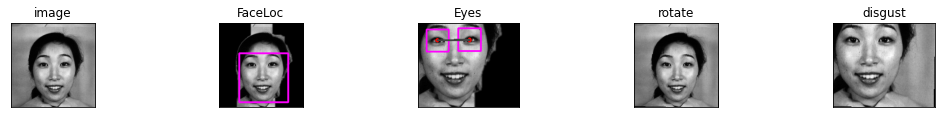

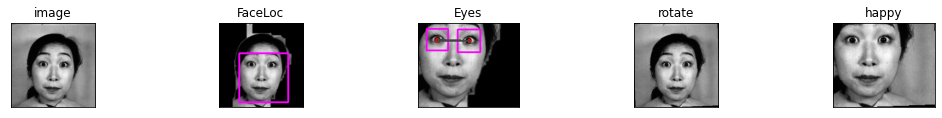

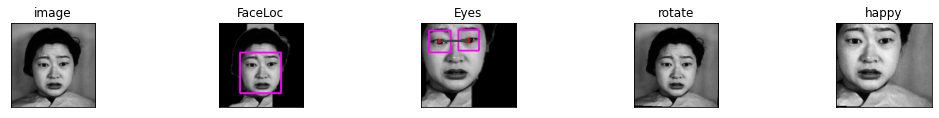

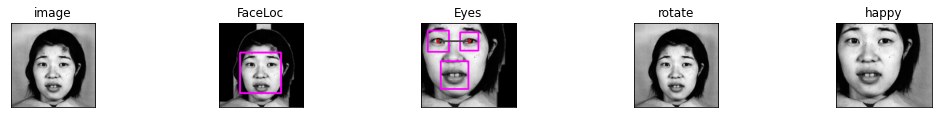

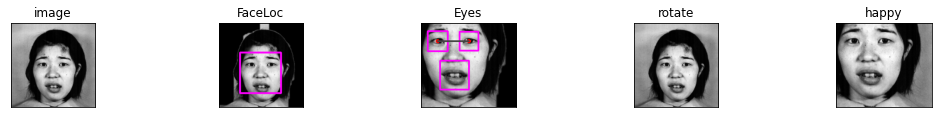

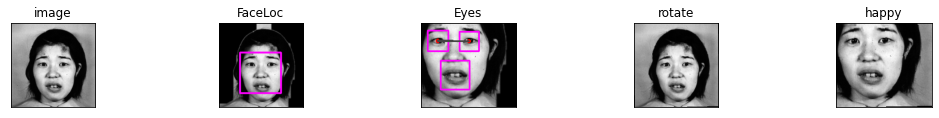

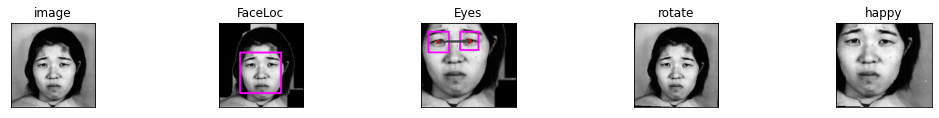

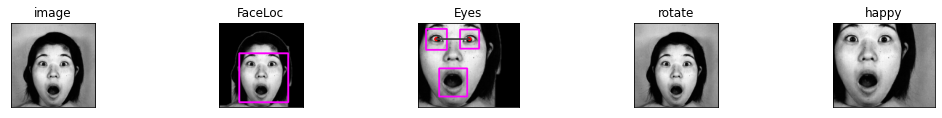

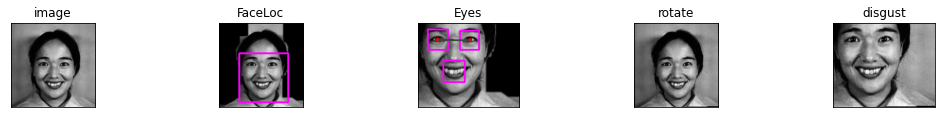

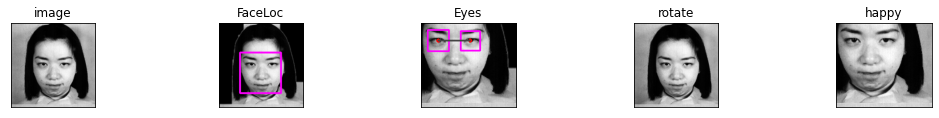

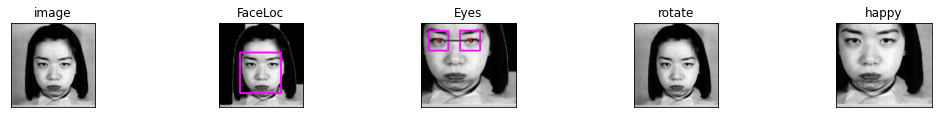

In [39]:
# train_images = [cv2.imread(file) for file in glob.glob(drive+'\\CK+48\\anger\\*')]

# test_images = [cv2.imread(file) for file in glob.glob(drive+'\\jaffe\\*')]


for img in test_images:
    
    img = cv2.resize(img, (img_size,img_size))
    img_raw = img.copy()
    #print(image)
    #img = cv2.imread(image)
    BLUR = 5
    CANNY_THRESH_1 = 100
    CANNY_THRESH_2 = 200
    MASK_DILATE_ITER = 20
    MASK_ERODE_ITER = 20
    MASK_COLOR = (0.0,0.0,0.0) # In BGR format
    
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #-- Edge detection -------------------------------------------------------------------
    cedges = cv2.Canny(grayimg, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(cedges, None)
    edges = cv2.erode(edges, None)

    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    sobelx = np.uint8(np.absolute(sobelx))
    sobely = np.uint8(np.absolute(sobely))
    
    #2Dimensional combine of sobel X & Y
    sobelcombine = cv2.bitwise_or(sobelx, sobely)
    
    threshold = cv2.threshold(grayimg, 127, 255, cv2.THRESH_BINARY)[1]
    ret, labels = cv2.connectedComponents(threshold)
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue==0] = 0
    
    #Gabor comparision
    def build_filters():
        filters = []
        ksize = 31
        for theta in np.arange(0, np.pi, np.pi / 16):
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
            return filters

    def process(img, filters):
        accum = np.zeros_like(img)
        for kern in filters:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            np.maximum(accum, fimg, accum)
            return accum
        
        
        
    filters=build_filters()
    res1=process(img,filters)
    
    #wavelet comparision
    n=5
    w='db1'
    
    coeffs = pywt.wavedecn(grayimg, wavelet=w, level=n)
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    
    Csort = np.sort(np.abs(coeff_arr.reshape(-1)))
    
    thresh = Csort[int(np.floor((1-0.2)*len(Csort)))]
    ind = np.abs(coeff_arr)>thresh
    Cfilt = coeff_arr*ind
    
    coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedecn')
    
    Arecon = pywt.waverecn(coeffs_filt, wavelet=w)
    
    #step3
    blur = cv2.GaussianBlur(Arecon.astype('uint8'),(5,3), 1) 
    mask=cv2.inRange(blur,50,200)
    
    res = 255 - mask
    #-----background removal------
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))
    # cv2.fillConvexPoly(mask, max_contour[0], (255))
    
    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    
    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending
    
    masked = (mask_stack * img) + ((1 - mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')
    
   
    #------Feature Extraction-------------
    corners = cv2.goodFeaturesToTrack(grayimg, 500, 0.01, 1)
    corners = np.int0(corners)
    
    cor_img = cv2.cvtColor(grayimg, cv2.COLOR_BGR2RGB)

    for i in corners:
        x, y = i.ravel()
        cv2.circle(cor_img, (x,y), 3, (255, 0, 255), -1)
    
    #-Step 5 :-----Face Detection----------------
    con_col_img = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
    faceLoc = face_recognition.face_locations(con_col_img)[0]
    endcodingFace = face_recognition.face_encodings(con_col_img)[0]
    cv2.rectangle(con_col_img, (faceLoc[3],faceLoc[0]), (faceLoc[1],faceLoc[2]), (255,0,255),3)
#     print(faceLoc[0])
#     print(faceLoc[1])
#     print(faceLoc[2])
#     print(faceLoc[3])
    
    #----Face Alignment------------------
    face_masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)    
    face_detector = cv2.CascadeClassifier(drive+"\\haarcascade_frontalface_default.xml")
    eye_detector = cv2.CascadeClassifier(drive+"\\haarcascade_eye.xml")
    faces = face_detector.detectMultiScale(face_masked, 2, 5)

    if(len(faces) == 0):
        faces = [[faceLoc[3],faceLoc[0], faceLoc[1],faceLoc[2]]]    
    face_x, face_y, face_w, face_h = faces[0]
#     print(faces)
   
    
    face_img = face_masked[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]
    face_gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    
    eyes = eye_detector.detectMultiScale(face_gray)
#     print(eyes)
    
    index = 0
    eye_1 = 0
    eye_2 = 0
    left_eye = 0
    right_eye = 0
    for (eye_x, eye_y, eye_w, eye_h) in eyes:
        if index == 0:
            eye_1 = (eye_x, eye_y, eye_w, eye_h)
        elif index == 1:
            eye_2 = (eye_x, eye_y, eye_w, eye_h)
            
        cv2.rectangle(face_img,(eye_x, eye_y),(eye_x+eye_w, eye_y+eye_h), (255,0,255), 2)
        index = index + 1
   

    if(eye_1 == 0):
        eye_1 = (42, 59, 44, 44)
    if(eye_2 == 0):
        eye_2 = (104, 61, 42, 42)
    if eye_1[0] < eye_2[0]:
        left_eye = eye_1
        right_eye = eye_2
    else:
        left_eye = eye_2
        right_eye = eye_1
    
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
    left_eye_x = left_eye_center[0]; 
    left_eye_y = left_eye_center[1]
 
    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    right_eye_x = right_eye_center[0]; 
    right_eye_y = right_eye_center[1]
 
    cv2.circle(face_img, left_eye_center, 2, (255, 0, 0) , 2)
    cv2.circle(face_img, right_eye_center, 2, (255, 0, 0) , 2)
    cv2.line(face_img,right_eye_center, left_eye_center,(67,67,67),2)
    
    point_3rd = 0
    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1 
        #rotate same direction to clock
        #print("rotate to clock direction")
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1 
        #rotate inverse direction of clock
        #print("rotate to inverse clock direction")
 
    cv2.circle(face_img, point_3rd, 2, (255, 0, 0) , 2)
 
    cv2.line(face_img,right_eye_center, left_eye_center,(67,67,67),2)
    cv2.line(face_img,left_eye_center, point_3rd,(67,67,67),2)
    cv2.line(face_img,right_eye_center, point_3rd,(67,67,67),2)
    
    def euclidean_distance(a, b):
        x1 = a[0]; y1 = a[1]
        x2 = b[0]; y2 = b[1]
        return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))
    a = euclidean_distance(left_eye_center, point_3rd)
    b = euclidean_distance(right_eye_center, left_eye_center)
    c = euclidean_distance(right_eye_center, point_3rd)
    
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    #print("cos(a) = ", cos_a)
 
    angle = np.arccos(cos_a)
    #print("angle: ", angle," in radian")
 
    angle = (angle * 180) / math.pi
    #print("angle: ", angle," in degree")
    
    if direction == -1:
        angle = 90 - angle
    
    rot_img = Image.fromarray(img_raw)
    rot_img = np.array(rot_img.rotate(direction * angle))
    
    gray_roi_img = cv2.cvtColor(rot_img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray_roi_img, 2, 5)
    
    if(len(faces) == 0):
        faces = [[faceLoc[3],faceLoc[0], faceLoc[1],faceLoc[2]]]    
    face_x, face_y, face_w, face_h = faces[0]
#     print(faces)
   
    
    face_new_img = gray_roi_img[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]
    #np.array(x).reshape(-1, img_size, img_size, 3)
#     final_img = cv2.resize(face_new_img, (224,224))
    final_img = cv2.resize(face_new_img, (224,224))
    
    final_img = np.expand_dims(final_img, axis=0)
    final_img = final_img/255.0;
#     final_img = np.expand_dims(final_img ,axis=-1)
    final_img = np.repeat(final_img[:, :, :,np.newaxis], 3, axis=-1)

    final_img = np.float32(final_img)[...,:3]
#     print(final_img.shape)
    Predictions = ck48_cnn_model.predict(final_img)
#     print(Predictions[0])
    min_max = np.argmax(Predictions)
#     print(classes[min_max])
#     model.summary()

#     titles = ['image', 'Edge', 'SX', 'SY', '2D', 'Hue', 'Gabo', 'wav', 'noise', 'bg', 'FE', 'FaceLoc','Eyes','rotate'] 
#     new_img = [img, cedges, sobelx, sobely, sobelcombine, labeled_img, res1, Arecon.astype('uint8'), res, masked, cor_img,con_col_img,face_img, rot_img]
    titles = ['image', 'FaceLoc','Eyes','rotate', classes[min_max]] 
    new_img = [img, con_col_img,face_img, rot_img, face_new_img]
    tot = len(new_img)
    plt.figure(figsize=(18, 9)) 
    for i in range(tot):
        #print(new_img)
        plt.subplot(tot, tot, i+1), plt.imshow(new_img[i], 'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
   
    